In [1]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

C:\Users\Almalis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=5)


X_train = pd.read_csv("Train.csv")

X_train_2 =X_train.sample(n = 2000)


x_train = X_train['Article']
y_train = X_train['Target']
x_train2 = X_train_2['Article']
y_train2 = X_train_2['Target']
#***************************************************************************
X_test  = pd.read_csv("Test.csv")
x_test  = X_test['Article']
y_test  = X_test['Target']
#**********************************************************************************

x_train  = tfidf_vectorizer.fit_transform(x_train.values.astype('U'))
x_test   = tfidf_vectorizer.transform(x_test.values.astype('U'))

x_train2  = tfidf_vectorizer.transform(x_train2.values.astype('U'))

x_train = pd.DataFrame(x_train.todense())
x_test  = pd.DataFrame(x_test.todense())
x_train2 = pd.DataFrame(x_train2.todense())

ros = RandomOverSampler()
x_train,y_train = ros.fit_resample(x_train, y_train)

## Naive Bayes

Normalized confusion matrix
[[0.841 0.018 0.046 0.059 0.013 0.023]
 [0.02  0.82  0.051 0.073 0.016 0.019]
 [0.037 0.029 0.799 0.061 0.038 0.037]
 [0.038 0.03  0.078 0.814 0.017 0.023]
 [0.003 0.009 0.045 0.015 0.921 0.006]
 [0.005 0.006 0.048 0.021 0.019 0.9  ]]


              precision    recall  f1-score   support

           0      0.924     0.841     0.880      8080
           1      0.896     0.820     0.856      5404
           2      0.786     0.799     0.792      5781
           3      0.794     0.814     0.804      6084
           4      0.666     0.921     0.773      1190
           5      0.706     0.900     0.791      1723

    accuracy                          0.830     28262
   macro avg      0.795     0.849     0.816     28262
weighted avg      0.838     0.830     0.831     28262



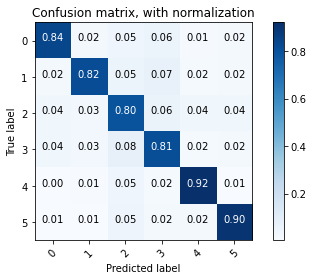

In [4]:
alpha = 0.6 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(x_train,y_train)
y_predicted = model.predict(x_test)

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0, 1, 2, 3, 4, 5])
np.set_printoptions(precision=3)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5],
                  title='Confusion matrix, with normalization')

print("\n")
print(metrics.classification_report(y_test, y_predicted, digits=3))

## Random Forest

In [5]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

model2 = RandomForestClassifier(max_features="auto")

rf_random = RandomizedSearchCV(estimator = model2, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42,n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train2, y_train2)

print(rf_random.best_params_)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 17.6min finished


{'n_estimators': 377, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 110, 'bootstrap': False}


In [6]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100, 110, 120],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4,5,6],
    'n_estimators': [350, 380, 430]
}
# Create a based model
model2 = RandomForestClassifier(max_features="auto")
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model2, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

grid_search.fit(x_train2, y_train2)
print(grid_search.best_params_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 15.5min finished


{'bootstrap': False, 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 430}



Metrics with OverSampling

 Recall metric: 0.8033639942508898
 F1 metric: 0.8036635999305571
 Precision metric: 0.8096574670779764
 Accuracy metric: 0.7839147972542637
 Balanced Accuracy metric: 0.8033639942508898 

**************************************************

Normalized confusion matrix
[[0.874 0.021 0.032 0.061 0.005 0.007]
 [0.119 0.764 0.031 0.078 0.004 0.005]
 [0.142 0.03  0.718 0.07  0.02  0.021]
 [0.189 0.04  0.059 0.701 0.003 0.008]
 [0.024 0.008 0.031 0.024 0.905 0.008]
 [0.068 0.005 0.024 0.035 0.008 0.86 ]]


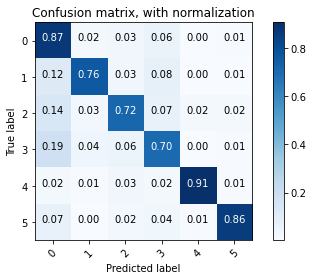

In [9]:
model2 = RandomForestClassifier(n_estimators=430, max_features="auto", bootstrap=False, 
                                max_depth =100, min_samples_leaf=2,min_samples_split = 4, n_jobs=-1)


model2.fit(x_train,y_train)
y_predicted = model2.predict(x_test)


print("\nMetrics with OverSampling\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0, 1, 2, 3, 4, 5])
np.set_printoptions(precision=3)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5],
                  title='Confusion matrix, with normalization')